# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Caleb Enriquez
* Roberto Chambi
* Carlos Marca

## Descripcion del Problema 

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling 

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [ ]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from pprint import pprint

from wordcloud import WordCloud

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [ ]:
# Opening JSON file 
f = open('/content/complaints.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

TENEMOS UN DATA FRAME DE 22 COLUMNAS CON 78313 ENTRADAS, CON LA MAYORIA DE LOS DATOS EN FORMATO OBJECT(String)  Y EL SCORE EN FLOAT64 que 

In [ ]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint', 'sub_issue','consumer_consent_provided']

In [ ]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaint',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
#seleccionamos las 4 columnas mas relevantes para clasificar las quejas en base a los productos/servicios
df = df[['issue','complaint','product','sub_product',]]
df

,issue,complaint,product,sub_product
0,Attempts to collect debt not owed,,Debt collection,Credit card debt
1,Written notification about debt,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,"Other features, terms, or problems",I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,Trouble during payment process,,Mortgage,Conventional home mortgage
4,Fees or interest,,Credit card or prepaid card,General-purpose credit card or charge card
...,...,...,...,...
78308,Closing an account,,Checking or savings account,Checking account
78309,"Other features, terms, or problems","On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,Problem with a lender or other company chargin...,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,"Other features, terms, or problems",I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].replace('', np.nan)

In [ ]:
#buscamos si existe valores vacios en la columna complaint
df.loc[df['complaint']==''].count()

issue          0
complaint      0
product        0
sub_product    0
dtype: int64

In [ ]:
#Remove all rows where complaints column is nan
df.isna().sum().sort_values(ascending=False)

complaint      57241
sub_product    10571
issue              0
product            0
dtype: int64

Existe 57241 valores Nulos en complaint y 10571 en Sub_product, donde primeramente eliminaremos los valores Nan en la columna complaint 

In [ ]:
df = df.dropna(subset=['complaint'])

In [ ]:
df.isna().sum().sort_values(ascending=False)

sub_product    2109
issue             0
complaint         0
product           0
dtype: int64

In [ ]:
#Cambiamos los valores Nan por None(no se tiene esa informacion) en la categoria de subproducto
df['sub_product'] = df['sub_product'].replace( np.nan,'None')

In [ ]:
df.isna().sum().sort_values(ascending=False).head(25)

issue          0
complaint      0
product        0
sub_product    0
dtype: int64

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
#Make the text lowercase
#Remove text in square brackets
#Remove punctuation
#Remove words containing numbers

def clean_text(text):
    if isinstance(text, str):  # Verificar si el valor es una cadena de texto
        text = text.lower() # Convertir a minúsculas
        text = re.sub('\[.*?\]', '', text) # Eliminar texto entre corchetes
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Eliminar puntuación
        text = re.sub('\w*\d\w*', '', text) # Eliminar palabras que contienen números
    return text



In [ ]:

df_complaint = pd.DataFrame( df['complaint'].apply(clean_text))

In [ ]:
df_complaint

,complaint
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [ ]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(lemmas)

In [ ]:
df_lemmatize = pd.DataFrame(df['complaint'].apply(lemmatize_text))


In [ ]:
df_lemmatize

,complaint
1,good morning xxxx xxxx appreciate help stop ch...
2,upgrade xxxx xxxx card xx tell agent upgrade a...
10,chase card report xx fraudulent application su...
11,xx try book xxxx xxxx ticket come offer apply ...
14,grand son check deposit chase account fund cle...
...,...
78303,chase card customer decade offer multiple soli...
78309,wednesday xx xx xxxx call chas xxxx xxxx visa ...
78310,familiar xxxx pay understand great risk provid...
78311,flawless credit yrs chase credit card chase fr...


In [ ]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.concat([df_complaint, df_lemmatize],axis='columns')
df_clean.columns = ['complaint', 'complaint_lemmatize']#renombramos la columna de df_lemmatize

In [ ]:
#tenemos el data frame con las quejas con lemmatize
df_clean

,complaint,complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...


In [ ]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return " ".join(nouns)



In [ ]:
 #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatize'].apply(pos_tag)

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

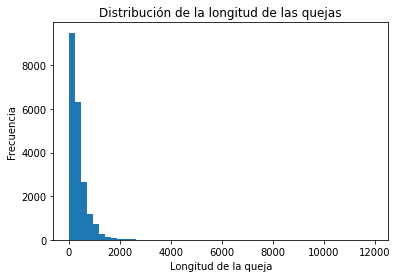

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaints = df_clean['complaint_POS_removed']
complaints_length = complaints.apply(len)
plt.hist(complaints_length, bins=50)
plt.xlabel('Longitud de la queja')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de las quejas')
plt.show()

SE OBSERVA QUE TIENE UNA DISTRIBUCION HACIA LA IZQUIERDA

#### Find the top 40 words by frequency among all the articles after processing the text.

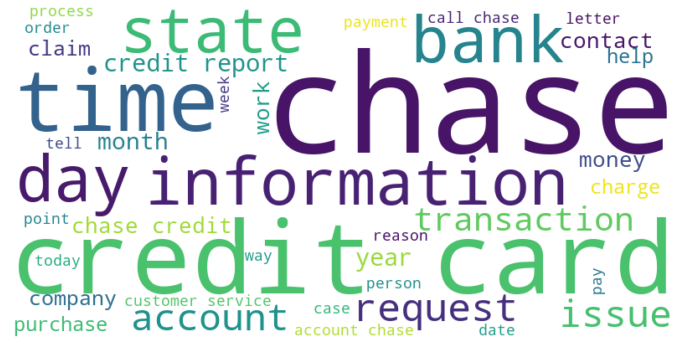

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
text = ' '.join(df_clean['complaint_POS_removed'])

wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(text)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

SE PUEDE VER QUE  LAS PALABRAS CON MAYOR RELEVANCIA SON

CHASE-CREDIT-CARD-TIME-INFORMATION-STATE

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Tokenizar los textos en palabras
tokens = nltk.word_tokenize(' '.join(df_clean['Complaint_clean']))

# Crear objeto FreqDist para contar la frecuencia de cada palabra
fdist = FreqDist(tokens)
# Imprimir las 30 palabras unigram más frecuentes
top_30_words = [(word, freq) for word, freq in fdist.most_common(30)]
df_unigram = pd.DataFrame(top_30_words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,55431
1,account,39675
2,credit,32347
3,card,29048
4,payment,20259
5,charge,16593
6,time,15382
7,day,11807
8,money,11672
9,bank,10956


In [ ]:
#Print the top 10 words in the unigram frequency
top_10_words = [(word, freq) for word, freq in fdist.most_common(10)]
df_unigram = pd.DataFrame(top_10_words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,55431
1,account,39675
2,credit,32347
3,card,29048
4,payment,20259
5,charge,16593
6,time,15382
7,day,11807
8,money,11672
9,bank,10956


EN EL WORLD CLOUD SE OBSERVABA QUE LAS PALABRAS MAS COMUNES ERAN 

CHASE-CREDIT-CARD-TIME-INFORMATION-STATE

PERO CON EL TOP 10 VEMOS QUE SON

CHASE-ACCOUNT-CREDIDT-CARD-PAYMENT

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
# Generate list of bigrams for each complaint
complaint_bigrams = [list(nltk.bigrams(word_tokenize(complaint))) for complaint in df_clean['Complaint_clean']]

# Flatten the list of bigrams
flat_bigrams = [bigram for sublist in complaint_bigrams for bigram in sublist]

# Get the top 30 bigrams by frequency
fdist_bigram = FreqDist(flat_bigrams)
top_30_bigrams = fdist_bigram.most_common(30)

# Create dataframe with top 30 bigrams and their frequency
df_bigrams = pd.DataFrame(top_30_bigrams, columns=['bigram', 'frequency'])

# Print the dataframe
df_bigrams

,bigram,frequency
0,"(credit, card)",12132
1,"(credit, report)",3562
2,"(chase, credit)",3090
3,"(customer, service)",2710
4,"(account, chase)",2435
5,"(call, chase)",2282
6,"(chase, account)",2155
7,"(debit, card)",1921
8,"(contact, chase)",1859
9,"(chase, bank)",1753


In [ ]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = fdist_bigram.most_common(10)
df_bigrams = pd.DataFrame(top_10_bigrams, columns=['bigram', 'frequency'])
df_bigrams

,bigram,frequency
0,"(credit, card)",12132
1,"(credit, report)",3562
2,"(chase, credit)",3090
3,"(customer, service)",2710
4,"(account, chase)",2435
5,"(call, chase)",2282
6,"(chase, account)",2155
7,"(debit, card)",1921
8,"(contact, chase)",1859
9,"(chase, bank)",1753


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
# Tokenize the complaints into trigrams
complaint_trigrams = [list(nltk.ngrams(word_tokenize(complaint), 3)) for complaint in df_clean['Complaint_clean']]

# Flatten the list of trigrams
flat_trigrams = [trigram for sublist in complaint_trigrams for trigram in sublist]

# Get frequency distribution of trigrams
fdist_trigram = nltk.FreqDist(flat_trigrams)

# Get the top 30 trigrams by frequency
top_30_trigrams = fdist_trigram.most_common(30)

df_trigrams = pd.DataFrame(top_30_trigrams, columns=['trigram', 'frequency'])
df_trigrams






,trigram,frequency
0,"(chase, credit, card)",2133
1,"(credit, card, account)",973
2,"(credit, card, company)",946
3,"(credit, card, chase)",780
4,"(chase, customer, service)",513
5,"(charge, credit, card)",478
6,"(inquiry, credit, report)",448
7,"(credit, card, credit)",432
8,"(file, police, report)",341
9,"(account, credit, card)",336


In [ ]:
#Print the top 10 words in the trigram frequency
top_10_trigrams = fdist_trigram.most_common(10)

df_trigrams = pd.DataFrame(top_10_trigrams, columns=['trigram', 'frequency'])
df_trigrams


,trigram,frequency
0,"(chase, credit, card)",2133
1,"(credit, card, account)",973
2,"(credit, card, company)",946
3,"(credit, card, chase)",780
4,"(chase, customer, service)",513
5,"(charge, credit, card)",478
6,"(inquiry, credit, report)",448
7,"(credit, card, credit)",432
8,"(file, police, report)",341
9,"(account, credit, card)",336


EN LOS BIGRAMAS Y LOS TRIGRAMAS SE VE QUE LAS PALABRAS CON MAYOR FRECUENCIA SON LA RELACIONADA A "CREDIT CARD"

### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...,book ticket reward card information offer minu...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Create the Document Term Matrix by transforming the 'Complaint_clean' column
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

# View the shape of the Document Term Matrix
print(dtm.shape)

(21072, 5859)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 6

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

5859

In [ ]:
#Print the Top15 words for each of the topics
nmf_components = nmf_model.components_

# Get the feature names (words)
feature_names = np.array(tfidf.get_feature_names())

# Create a DataFrame to store the top 15 words for each topic
topics = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)],
                           columns=[f'Word {i+1}' for i in range(15)]).astype(str)

# For each topic, get the indices of the top 15 words and store them in the DataFrame
for i in range(num_topics):
    word_indices = nmf_components[i].argsort()[::-1][:15]
    topics.iloc[i] = feature_names[word_indices]

# Print the DataFrame
topics

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,chase,deposit,bank,fund,day,branch,transfer,number,transaction,checking,claim,business
Topic 2,card,credit,chase,purchase,balance,score,limit,year,point,account,time,company,number,letter,issue
Topic 3,payment,balance,pay,month,statement,fee,auto,time,credit,day,chase,date,account,year,mortgage
Topic 4,charge,fee,dispute,transaction,merchant,chase,refund,overdraft,purchase,balance,claim,pay,service,statement,fraud
Topic 5,loan,mortgage,chase,home,modification,property,year,document,letter,time,rate,request,foreclosure,sale,information
Topic 6,report,inquiry,credit,company,information,remove,debt,identity,reporting,account,theft,score,file,dispute,request


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3, 4 & 5

topic_distribution = nmf_model.transform(dtm)


In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_distribution.argmax(axis=1)

In [ ]:
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...,chase card report application submit identity ...,chase card report application submit identity ...,5
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...,book ticket reward card information offer minu...,1
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,4
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,0
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,2


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_groupby=df_clean.groupby('Topic').head(5)
df_clean_groupby.sort_values('Topic')

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
21,on xxxx i made a payment to an online retail...,xxxx xx payment online retailer chase quick pa...,retailer chase pay website scam website confir...,retailer chase pay website scam website confir...,0
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,account chase auto,account chase auto,0
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
17,with out notice jp morgan chase restricted my ...,notice morgan chase restrict account debit car...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,amazon card catering order place brother conta...,amazon card catering order place brother conta...,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card credit report company issue,chase credit card credit report company issue,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,steal chase debit card driver license money ac...,steal chase debit card driver license money ac...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ti...,citizen company time share company refund cred...,citizen company time share company refund cred...,1
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...,book ticket reward card information offer minu...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* topic1 : Bank Account services
* topic2 : Credit card or prepaid card
* topic3 : Pay/Account Statement
* topic4 : Account Problems
* topic5 : Loans/Properties
* topic6 : Credit Reports/Scores

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Pay/Account Statement",
               3:"Account Problems", 4:"Loans/Properties",5:"Credit Reports/Scores" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,Loans/Properties
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,Bank Account services
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...,chase card report application submit identity ...,chase card report application submit identity ...,Credit Reports/Scores
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...,book ticket reward card information offer minu...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,Loans/Properties
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,Bank Account services
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Pay/Account Statement


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [ ]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank Account services":0, "Credit card or prepaid card":1, "Pay/Account Statement":2,
               "Account Problems":3, "Loans/Properties":4,"Credit Reports/Scores":5 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint,complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card xx tell agent upgrade a...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent...,chase card report xx fraudulent application su...,chase card report application submit identity ...,chase card report application submit identity ...,5
11,on while trying to book a xxxx xxxx ticket ...,xx try book xxxx xxxx ticket come offer apply ...,book ticket reward card information offer minu...,book ticket reward card information offer minu...,1
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,4
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,0
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs chase credit card chase fr...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,2


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint', 'Topic']]

In [ ]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told ...,0
10,chase card was reported on however fraudulent...,5
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs ive had ch...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)
y_train = training_data['Topic']

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:

accuracy_list = [accuracy_lr*100, accuracy_dt*100,accuracy_rf*100, accuracy_nb*100]

##Logistic Regression

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=40)



In [ ]:
# Train a logistic regression model
lr_model = LogisticRegression(random_state=40)
lr_model.fit(X_train, y_train)

# Evaluate the performance on the test set
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)


print("Logistic Regression Accuracy:", accuracy_lr)
print("--------------------------------------------------------")
print("Matriz de Confusion:")
print(conf_matrix_lr)
print("--------------------------------------------------------")
print("Clasificador:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.902491103202847
--------------------------------------------------------
Matriz de Confusion:
[[955  15   2  12  22   6]
 [ 27 781   9  20  14  10]
 [ 24  10 404  12  16   2]
 [ 31  24   7 599  12   8]
 [ 24   9  14  12 769   7]
 [ 12  25   2   4  19 296]]
--------------------------------------------------------
Clasificador:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1012
           1       0.90      0.91      0.91       861
           2       0.92      0.86      0.89       468
           3       0.91      0.88      0.89       681
           4       0.90      0.92      0.91       835
           5       0.90      0.83      0.86       358

    accuracy                           0.90      4215
   macro avg       0.90      0.89      0.90      4215
weighted avg       0.90      0.90      0.90      4215



EN LOGISTIC REGRESSION TENEMOS UN ACCURACY DE UN 90.24% LO CUAL ES UN BUEN MODELO 

TAMBIEN PODEMOS VER QUE LA PRECISION EN PREDECIR LOS TOPICOS NO VARIA DEMASIADO  DANDO UNA PRESICION PROMEDIA DE 90%

##DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Train a desicion tree model
dt_model = DecisionTreeClassifier(random_state=40)
dt_model.fit(X_train, y_train)

# Evaluate the performance on the test set
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Logistic Regression Accuracy:", accuracy_dt)
print("--------------------------------------------------------")
print("Matriz de Confusion:")
print(conf_matrix_dt)
print("--------------------------------------------------------")
print("Clasificador:")
print(classification_report(y_test, y_pred_dt))

Logistic Regression Accuracy: 0.7629893238434163
--------------------------------------------------------
Matriz de Confusion:
[[800  39  20  60  67  26]
 [ 47 671  20  63  24  36]
 [ 21  24 350  22  45   6]
 [ 73  64  20 471  40  13]
 [ 61  21  41  29 659  24]
 [ 24  31  12   6  20 265]]
--------------------------------------------------------
Clasificador:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1012
           1       0.79      0.78      0.78       861
           2       0.76      0.75      0.75       468
           3       0.72      0.69      0.71       681
           4       0.77      0.79      0.78       835
           5       0.72      0.74      0.73       358

    accuracy                           0.76      4215
   macro avg       0.76      0.76      0.76      4215
weighted avg       0.76      0.76      0.76      4215



EN DESICION TREE TENEMOS UN ACCURACY DE UN 76.29% LO CUAL ES UN MODELO RELATIVAMENTE ACEPTABLE PERO NO EN COMPARACION AL LOGISTIC REGRESSION

TAMBIEN PODEMOS VER QUE LA PRECISION EN PREDECIR LOS TOPICOS VARIA MUY POCO EN LOS TOPICOS 3 Y 5 QUE TIENEN UNA PRESICION DE 72  Y UNA PRECISION PROMEDIO DE 76

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=40)
rf_model.fit(X_train, y_train)

# Evaluate the performance on the test set
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Logistic Regression Accuracy:", accuracy_rf)
print("--------------------------------------------------------")
print("Matriz de Confusion:")
print(conf_matrix_rf)
print("--------------------------------------------------------")
print("Clasificador:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Accuracy: 0.7845788849347568
--------------------------------------------------------
Matriz de Confusion:
[[944  34   3  13  15   3]
 [ 86 695   3  53   8  16]
 [ 76  51 235  22  79   5]
 [ 93  73   5 483  21   6]
 [ 77  29  13  16 695   5]
 [ 13  55   4   6  25 255]]
--------------------------------------------------------
Clasificador:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1012
           1       0.74      0.81      0.77       861
           2       0.89      0.50      0.64       468
           3       0.81      0.71      0.76       681
           4       0.82      0.83      0.83       835
           5       0.88      0.71      0.79       358

    accuracy                           0.78      4215
   macro avg       0.81      0.75      0.77      4215
weighted avg       0.80      0.78      0.78      4215



EN RANDOM FOREST AL IGUAL QUE DESICION TREE EL ACCURACY ES DE 78.45 LO CUAL SE CONSIDERARIA UN MODELO ACEPTABLE PERO NO EL MEJOR

TAMBIEN PODEMOS VER QUE LA PRECISION EN PREDECIR LOS TOPICOS VARIA , EN LOS TOPICOS 0 Y 1 QUE TIENEN UNA PRESICION DE 73 Y 74 LO CUAL SE CONSIDERARIA MUY BAJA Y UNA PRECISION PROMEDIO DE 81

##Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Train a Random Forest model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluate the performance on the test set
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print("Logistic Regression Accuracy:", accuracy_nb)
print("--------------------------------------------------------")
print("Matriz de Confusion:")
print(conf_matrix_nb)
print("--------------------------------------------------------")
print("Clasificador:")
print(classification_report(y_test, y_pred_nb))

Logistic Regression Accuracy: 0.5852906287069988
--------------------------------------------------------
Matriz de Confusion:
[[971  21   2   1  17   0]
 [238 585   0  15  23   0]
 [168 129  22   4 145   0]
 [320 162   0 175  24   0]
 [131  33   1   4 666   0]
 [ 85 165   0   2  58  48]]
--------------------------------------------------------
Clasificador:
              precision    recall  f1-score   support

           0       0.51      0.96      0.66      1012
           1       0.53      0.68      0.60       861
           2       0.88      0.05      0.09       468
           3       0.87      0.26      0.40       681
           4       0.71      0.80      0.75       835
           5       1.00      0.13      0.24       358

    accuracy                           0.59      4215
   macro avg       0.75      0.48      0.46      4215
weighted avg       0.70      0.59      0.52      4215



EN NAIVE BAYES SE UTILIZO EL NAIVEBAYES MULTINOMIAL YA QUE ESTE ESTA DISENADO PARA TRABAJAR CON TEXTO

TENEMOS UN ACCURRACY DE 58.52% LO CUAL ES UN MODELO PARA NADA ACEPTABLE 

Y EN LA PRESICION PODEMOS VER QUE CADA TOPICO TIENE PRECISIONES MUY DIFERENTES DE HASTA UN 100% EN EL TOPICO 5 LO CUAL SE REQUERIRIA UN ANALISIS MAS DETALLADO 

#RESULTADOS

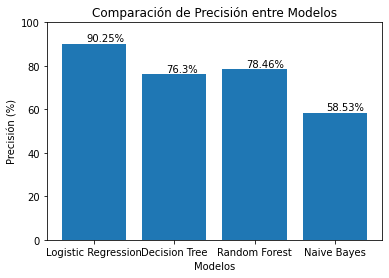

In [ ]:
plt.bar(['Logistic Regression', 'Decision Tree','Random Forest','Naive Bayes'], accuracy_list)
plt.xlabel('Modelos')
plt.ylabel('Precisión (%)')
plt.title('Comparación de Precisión entre Modelos')
plt.ylim([0, 100])
for i, v in enumerate(accuracy_list):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) + '%')
plt.show()

EL MEJOR MODELO PARA PREDECIR LOS TOPICOS EN LAS QUEJAS DE LOS CLIENTES ES SIN NINGUNA DUDA EL RANDOM FOREST DANDONOS UNA ACCURACY DE 90.25%  Y UNA PRECISION DE 90% LO CUAL LO CONSIDERARIAMOS UN MUY BUEN MODELO Y EL QUE DEBERIA SER TOMADO EN CUENTA PARA FUTURAS CLASIFICACIONES.